# Learning Graph Structured Data on Manifolds

## Description
Learning Graph Structured Data (GSD) embeddings on manifolds received considerable attention. Recently, many works showed the benefits
of embedding GSD in hyperbolic space. In this trend, this tutorial shows how to learn embedding in the Poincaré Ball in `geomstats`. The method is applied
to a practical and known GSD dataset, the Karate club. The latter and several other datasets are found in the `datasets.data` module.

## Set up

We start by importing the logging module, to provide practical information throughout the embedding learning process.
`matplotlib` and the `visualization` module will help us draw the embedding of the GSD on the manifold. The backend is imported
and the `PoincareBall` manifold from the `geometry` module. A specific class for managing graph data is imported as well.


In [2]:
import logging

import matplotlib.pyplot as plt

import geomstats.backend as gs
import geomstats.datasets.utils
import geomstats.visualization as visualization
from geomstats.datasets import graph_data_preparation as gdp
from geomstats.geometry.poincare_ball import PoincareBall

INFO: Using tensorflow backend


Two variables are set as the path to the dataset and a second to the true 
labels of the dataset. The Karate club his is the well-known and much-used Zachary karate club network.
 The data was collected from the members of a university karate club by Wayne Zachary in 1977. 
 Each node represents a member of the club, and each edge represents a tie between two members 
 of the club. The network is undirected. An often discussed problem using this dataset is to find the
  two groups of people into which the karate club split after an argument between two teachers.

In [ ]:
GRAPH_MATRIX_PATH = geomstats.datasets.utils.KARATE_PATH
LABELS_PATH = geomstats.datasets.utils.KARATE_LABELS_PATH

The main function is defined, we will set some important parameters for performing the embedding. A random seed
as a basis for all randomly generated numbers. The number of dimensions of the manifold that will be used in embedding.
It is recommended to use a higher number of dimensions for large datasets (i.e., where the number of nodes/edges is significantly large).
The considered dataset is quite small with only 34 nodes, therefore the Poincaré disk of two dimensions is sufficient to
provide a faithful representation.
The number of epochs for learning the embedding is set, this parameter should be considered as a hyperparameter and
should be tuned specifically to the dataset.

In [ ]:
def main():
    gs.random.seed(1234)
    dim = 2
    max_epochs = 100
    lr = .05
    n_negative = 2
    context_size = 1
    karate_graph = gdp.Graph(
        graph_matrix_path=GRAPH_MATRIX_PATH,
        labels_path=LABELS_PATH)

    nb_vertices_by_edges =\
        [len(e_2) for _, e_2 in karate_graph.edges.items()]
    logging.info('Number of edges: %s', len(karate_graph.edges))
    logging.info(
        'Mean vertices by edges: %s',
        (sum(nb_vertices_by_edges, 0) / len(karate_graph.edges)))

In [ ]:
    negative_table_parameter = 5
    negative_sampling_table = []

    for i, nb_v in enumerate(nb_vertices_by_edges):
        negative_sampling_table +=\
            ([i] * int((nb_v**(3. / 4.))) * negative_table_parameter)

    negative_sampling_table = gs.array(negative_sampling_table)
    random_walks = karate_graph.random_walk()
    embeddings = gs.random.normal(size=(karate_graph.n_nodes, dim))
    embeddings = embeddings * 0.2

    hyperbolic_manifold = PoincareBall(2)

    colors = {1: 'b', 2: 'r'}
    for epoch in range(max_epochs):
        total_loss = []
        for path in random_walks:

            for example_index, one_path in enumerate(path):
                context_index = path[max(0, example_index - context_size):
                                     min(example_index + context_size,
                                     len(path))]
                negative_index =\
                    gs.random.randint(negative_sampling_table.shape[0],
                                      size=(len(context_index),
                                      n_negative))
                negative_index = negative_sampling_table[negative_index]

                example_embedding = embeddings[one_path]

                for one_context_i, one_negative_i in zip(context_index,
                                                         negative_index):
                    context_embedding = embeddings[one_context_i]
                    negative_embedding = embeddings[one_negative_i]
                    l, g_ex = loss(
                        example_embedding,
                        context_embedding,
                        negative_embedding,
                        hyperbolic_manifold)
                    total_loss.append(l)

                    example_to_update = embeddings[one_path]
                    embeddings[one_path] = hyperbolic_manifold.metric.exp(
                        -lr * g_ex, example_to_update)

        logging.info(
            'iteration %d loss_value %f',
            epoch, sum(total_loss, 0) / len(total_loss))

    circle = visualization.PoincareDisk(point_type='ball')
    plt.figure()
    ax = plt.subplot(111)
    circle.add_points(gs.array([[0, 0]]))
    circle.set_ax(ax)
    circle.draw(ax=ax)
    for i_embedding, embedding in enumerate(embeddings):
        plt.scatter(
            embedding[0], embedding[1],
            c=colors[karate_graph.labels[i_embedding][0]])
    plt.show()

In [ ]:
def log_sigmoid(vector):
    """Logsigmoid function.

    Apply log sigmoid function

    Parameters
    ----------
    vector : array-like, shape=[n_samples, dim]

    Returns
    -------
    result : array-like, shape=[n_samples, dim]
    """
    return gs.log((1 / (1 + gs.exp(-vector))))


def grad_log_sigmoid(vector):
    """Gradient of log sigmoid function.

    Parameters
    ----------
    vector : array-like, shape=[n_samples, dim]

    Returns
    -------
    gradient : array-like, shape=[n_samples, dim]
    """
    return 1 / (1 + gs.exp(vector))


def grad_squared_distance(point_a, point_b):
    """Gradient of squared hyperbolic distance.

    Gradient of the squared distance based on the
    Ball representation according to point_a

    Parameters
    ----------
    point_a : array-like, shape=[n_samples, dim]
        First point in hyperbolic space.
    point_b : array-like, shape=[n_samples, dim]
        Second point in hyperbolic space.

    Returns
    -------
    dist : array-like, shape=[n_samples, 1]
        Geodesic squared distance between the two points.
    """
    hyperbolic_metric = PoincareBall(2).metric
    log_map = hyperbolic_metric.log(point_b, point_a)

    return -2 * log_map


def loss(example_embedding, context_embedding, negative_embedding,
         manifold):
    """Compute loss and grad.

    Compute loss and grad given embedding of the current example,
    embedding of the context and negative sampling embedding.
    """
    n_edges, dim =\
        negative_embedding.shape[0], example_embedding.shape[-1]
    example_embedding = gs.expand_dims(example_embedding, 0)
    context_embedding = gs.expand_dims(context_embedding, 0)

    positive_distance =\
        manifold.metric.squared_dist(
            example_embedding, context_embedding)
    positive_loss =\
        log_sigmoid(-positive_distance)

    reshaped_example_embedding =\
        gs.repeat(example_embedding, n_edges, axis=0)

    negative_distance =\
        manifold.metric.squared_dist(
            reshaped_example_embedding, negative_embedding)
    negative_loss = log_sigmoid(negative_distance)

    total_loss = -(positive_loss + negative_loss.sum())

    positive_log_sigmoid_grad =\
        -grad_log_sigmoid(-positive_distance)

    positive_distance_grad =\
        grad_squared_distance(example_embedding, context_embedding)

    positive_grad =\
        gs.repeat(positive_log_sigmoid_grad, dim, axis=-1)\
        * positive_distance_grad

    negative_distance_grad =\
        grad_squared_distance(reshaped_example_embedding, negative_embedding)

    negative_distance = gs.to_ndarray(negative_distance,
                                      to_ndim=2, axis=-1)
    negative_log_sigmoid_grad =\
        grad_log_sigmoid(negative_distance)

    negative_grad = negative_log_sigmoid_grad\
        * negative_distance_grad

    example_grad = -(positive_grad + negative_grad.sum(axis=0))

    return total_loss, example_grad





if __name__ == '__main__':
    main()


Finally, we import the visualization module.import the visualization module.

In [3]:
import matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

import geomstats.visualization as visualization

visualization.tutorial_matplotlib()

## From data on linear spaces to data on manifolds

The **science of Statistics** is defined as the collection of data, their analysis and interpretation. Statistical theory is usually defined for data belonging to vector spaces, which are _linear spaces_. For example, we know how to compute the mean of a data set of numbers, like the mean of students' weights in a classroom, or of multidimensional arrays, like the average 3D velocity vector of blood cells in a vessel.

Here is an example of the computation of the mean of two arrays of dimension 2.

In [4]:
from geomstats.geometry.euclidean import Euclidean

dim = 2
n_samples = 2

euclidean = Euclidean(dim=dim)
points_in_linear_space = euclidean.random_uniform(n_samples=n_samples)
print('Points in linear space:\n', points_in_linear_space)

linear_mean = gs.sum(points_in_linear_space, axis=0) / n_samples
print('Mean of points:\n', linear_mean)

Points in linear space:
 tf.Tensor(
[[ 0.5739341   0.95338917]
 [-0.6382277  -0.65808535]], shape=(2, 2), dtype=float32)
Mean of points:
 tf.Tensor([-0.03214681  0.14765191], shape=(2,), dtype=float32)


We plot the points and their mean on the 2D Euclidean space, which is a linear space: a plane.

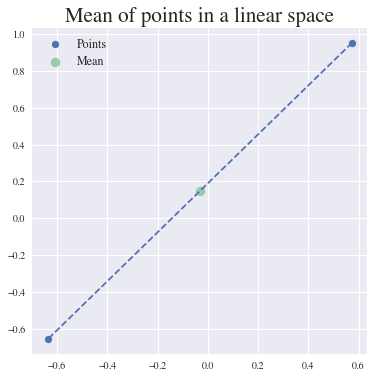

In [5]:
%matplotlib inline

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)

ax.scatter(points_in_linear_space[:, 0], points_in_linear_space[:, 1], label='Points')
ax.plot(points_in_linear_space[:, 0], points_in_linear_space[:, 1], linestyle='dashed')

ax.scatter(
    gs.to_numpy(linear_mean[0]), 
    gs.to_numpy(linear_mean[1]), label='Mean', s=80, alpha=0.5)

ax.set_title('Mean of points in a linear space')
ax.legend();

What happens to the usual statistical theory when the data doesn't naturally belong to a linear space. For example, if we want to perform statistics on the coordinates of world cities, which lie on the earth: a sphere? 

The non-linear spaces we consider are called manifolds. A **manifold $M$ of dimension $m$** is a space that is allowed to be curved but that looks like an $m$-dimensional vector space in the neighborhood of every point. 

A sphere, like the earth, is a good example of a manifold. We know that the earth is curved, but at our scale we do not see its curvature. Can we still use linear statistics when data are defined on these manifolds, or shall we? 

Let's try.

In [6]:
from geomstats.geometry.hypersphere import Hypersphere

sphere = Hypersphere(dim=dim)
points_in_manifold = sphere.random_uniform(n_samples=n_samples)
print('Points in manifold:\n', points_in_manifold)

linear_mean = gs.sum(points_in_manifold, axis=0) / n_samples
print('Mean of points:\n', linear_mean)

Points in manifold:
 tf.Tensor(
[[ 0.42310703 -0.67839897 -0.60062903]
 [-0.34749958  0.6196765  -0.7037366 ]], shape=(2, 3), dtype=float32)
Mean of points:
 tf.Tensor([ 0.03780372 -0.02936125 -0.6521828 ], shape=(3,), dtype=float32)


We plot the points and their mean computed with the linear formula.

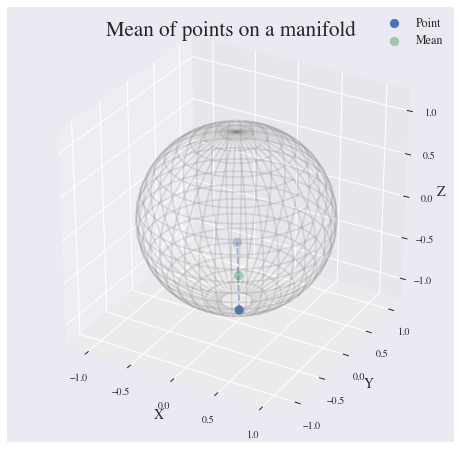

In [7]:
%matplotlib inline

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

visualization.plot(
    points_in_manifold, ax=ax, space='S2', label='Point', s=80)

ax.plot(
    points_in_manifold[:, 0], 
    points_in_manifold[:, 1], 
    points_in_manifold[:, 2], 
    linestyle='dashed', alpha=0.5)

ax.scatter(
    linear_mean[0], linear_mean[1], linear_mean[2], 
    label='Mean', s=80, alpha=0.5)

ax.set_title('Mean of points on a manifold')
ax.legend();

What happened? The mean of two points on a manifold (the sphere) is not on the manifold. In our example, the mean city is not on the earth. This leads to errors in statistical computations.

In [8]:
print(sphere.belongs(linear_mean))

tf.Tensor(False, shape=(), dtype=bool)


For this reason, researchers aim to build a theory of statistics that is by construction compatible with any structure we equip the manifold with. This theory is called _Geometric Statistics_.

**Geometric Statistics** is a theory of statistics on manifolds, that takes into account their geometric structures. Geometric Statistics is therefore the child of two major pillars of Mathematics: Geometry and Statistics.

## Examples of data on manifolds

Why should we bother to build a whole new theory of statistics? Do we really have data that belong to spaces like the sphere illustrated in introduction?

Let's see some examples of data spaces that are naturally manifolds. By doing so, we will introduce the `datasets` and `visualization` modules of `geomstats`.

We first import the `datasets.utils` module that allows loading datasets.

In [9]:
import geomstats.datasets.utils as data_utils

### World cities: data on the sphere

We load the dataset `cities`, that contains the coordinates of world cities in spherical coordinates.

In [10]:
data, names = data_utils.load_cities()
print(names[:5])
print(data[:5])

['Tokyo', 'New York', 'Mexico City', 'Mumbai', 'São Paulo']
tf.Tensor(
[[ 0.61993796 -0.5247902   0.58332855]
 [-0.2099432   0.7285533   0.65202296]
 [ 0.14964306  0.9310273   0.332859  ]
 [-0.27867043 -0.9034187   0.3258487 ]
 [-0.6295288   0.6662901  -0.39968845]], shape=(5, 3), dtype=float32)


We convert the spherical coordinates to X, Y, Z coordinates and verify that they belong to the sphere.

In [11]:
gs.all(sphere.belongs(data))

<tf.Tensor: shape=(), dtype=bool, numpy=True>

Now, we plot the cities on the sphere. We choose only a subset of the cities that have a nice rendering in the 2D plot of the 3D earth. This plot is nicer shown in an interactive 3D figure.

In [12]:
data, names = data_utils.load_cities()

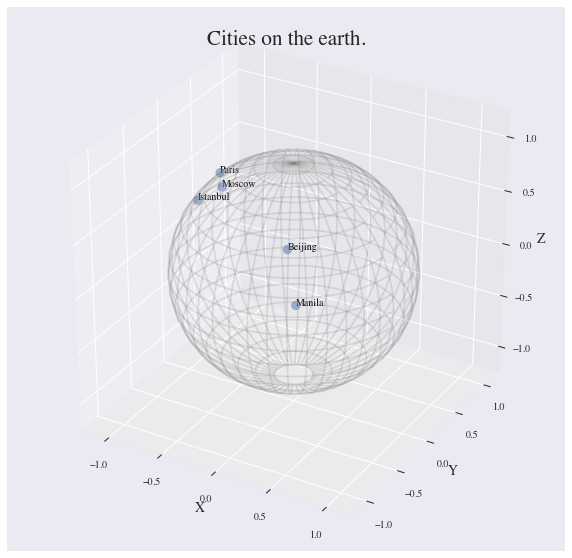

In [13]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

visualization.plot(data[15:20], ax=ax, space='S2', label=names[15:20], s=80, alpha=0.5)

ax.set_title('Cities on the earth.');

### Pose of objects in pictures

We consider the dataset `poses`, that contains the 3D poses of objects in images. Specifically, we consider poses of beds in images, i.e. the 3D orientation of each bed within a given 2D image. 

The orientation corresponds to a 3D rotation. A 3D rotation $R$ is visually represented as the result of $R$ applied to the coordinate frame $(e_x, e_y, e_z)$.

We first load the dataset.

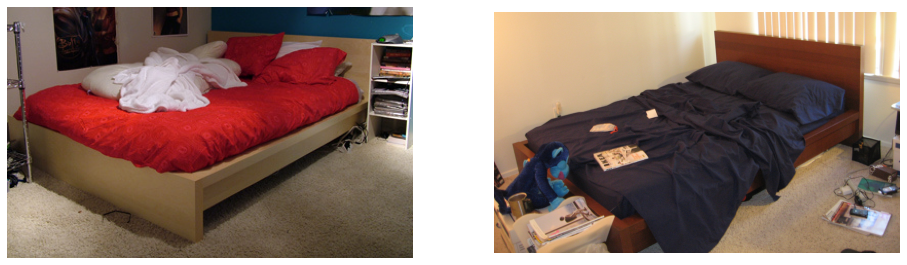

In [14]:
data, img_paths = data_utils.load_poses()

img_path1, img_path2 = img_paths[0], img_paths[1]
img_path1 = os.path.join(data_utils.DATA_FOLDER, 'poses', img_path1)
img_path2 = os.path.join(data_utils.DATA_FOLDER, 'poses', img_path2)

img1 = mpimg.imread(img_path1)
img2 = mpimg.imread(img_path2)

fig = plt.figure(figsize=(16, 8))

ax = fig.add_subplot(121)
imgplot = ax.imshow(img1)
ax.axis('off')
ax = fig.add_subplot(122)
imgplot = ax.imshow(img2)
ax.axis('off')

plt.show()

We import the manifold of 3D rotations: the Special Orthogonal group in 3D, $SO(3)$. We choose to represent the 3D rotations as rotation vectors, hence: `point_type='vector'`.

In [15]:
from geomstats.geometry.special_orthogonal import SpecialOrthogonal

so3 = SpecialOrthogonal(n=3, point_type='vector')

We verify that the poses belong to the space of 3D rotations.

In [16]:
gs.all(so3.belongs(data))

<tf.Tensor: shape=(), dtype=bool, numpy=True>

We plot the orientations of the first 2 beds.

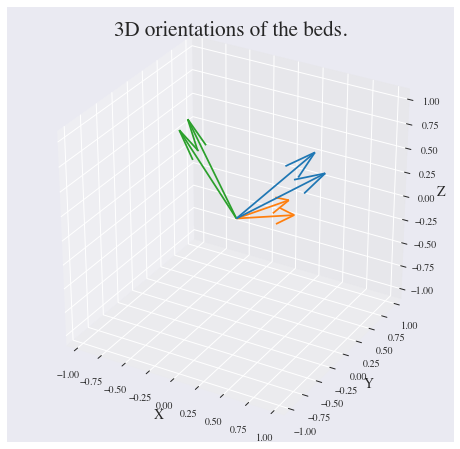

In [17]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

visualization.plot(data[:2], ax=ax, space='SO3_GROUP')

ax.set_title('3D orientations of the beds.');

These orientations are very close, as expected from the corresponding images.